# Purpose

In Notebook 09.0x we took embeddings created by other models/steps & combined them:
```
new post = post + comments + subreddit description

new subreddit = new posts (weighted by post length)
```

In this notebook (nb 11), we'll focus on visualizing those embeddings.

# Notebook setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
import gc
import os
import logging

import fse
from fse.models import uSIF
import gensim
from gensim.models.fasttext import FastText, load_facebook_vectors
import joblib

import numpy as np
import pandas as pd
import plotly
import plotly.express as px

import mlflow

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import umap

from subclu.data.fasttext import (
    download_ft_pretrained_model,
    get_df_for_most_similar,
    get_project_subfolder,
)
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language,
    get_language_by_sub_wide,
    get_language_by_sub_long,
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([fse, gensim, joblib, np, pd, plotly, umap])

python		v 3.7.10
===
fse		v: 0.1.15
gensim		v: 3.8.3
joblib		v: 1.0.1
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
umap		v: 0.5.1


In [4]:
# plotting

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Provenance of data

The jobs used to create these embeddings came from these jobs:
- Subreddit descriptions: `84dd5a3878534f72b6442bcc0e4c8b95`
- Comments & posts: `3bf280ee76fc4595afc5e8cbaaf79a7d`

They were merged in notebook: `djb_09.00....ipynb`

Let's create a new uuid for this model?

In [5]:
path_this_ft_model = get_project_subfolder(
    f"data/models/fse/manual_merge_2021-06-07_17"
)
path_this_ft_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17')

In [6]:
# list(f_.name for f_ in path_this_ft_model.glob('*.parquet'))

In [7]:
bucket_upload_dir = f'gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17'

In [8]:
# !gsutil ls -r $bucket_upload_dir

# Load compressed vectors

In [9]:
%%time

df_v_posts_merged_tsne2 = pd.read_parquet(
    path_this_ft_model / 
    'df_vectorized_posts_svd_tsne-init_pca-perplexity_30-rand_state_42-ids_index-111669_by_2.parquet'
)
df_v_posts_merged_tsne2.shape

CPU times: user 230 ms, sys: 33.1 ms, total: 263 ms
Wall time: 234 ms


(111669, 2)

In [12]:
%%time

df_v_subs_merged_tsne2 = pd.read_parquet(
    path_this_ft_model / 
    'df_vectorized_subs_svd_tsne-agg_to_subreddit-ids_index-167_by_2.parquet'
)
df_v_subs_merged_tsne2.shape

CPU times: user 5.85 ms, sys: 13.2 ms, total: 19.1 ms
Wall time: 14.2 ms


(167, 2)

# Load post & comment metadata

In [14]:
l_large_nsfw_subs = [
    'wixbros', 'katjakrasavicenudes',
    'deutschetributes', 'germannudes',
    'annitheduck', 'germanonlyfans',
    'loredana', 'nicoledobrikovof',
    'germansgonewild', 'elisaalinenudes',
    'marialoeffler', 'germanwomenandcouples',
    'germancelebritiesfap2', 'germancelebs',
    'nicoledobrikov', 'elisaaline1',
    'nicoledobrikov1', 'nicoledobrikovofs', 'germanpornstuff',
]

## Load & preprocess posts

In [15]:
%%time

project_id='data-science-prod'
bucket_name = 'i18n-subreddit-clustering'
folder_posts = 'posts/2021-05-19'

l_cols_load = [
    # IDs
    'subreddit_name',
    'subreddit_id',
    'post_id',
#     'user_id',
#     'thing_type',
    
    # Meta
    'submit_date',
#     'removed',
    'upvotes',
#     'successful',
#     'app_name',
    'combined_topic_and_rating',
    'post_type',
    'post_nsfw',
    'geolocation_country_code',
    
    # Language & text content
    'post_url',
    'language',
    'probability',
    'weighted_language',
    'weighted_language_probability',
    'text_len',
    'text_word_count',
    'post_url_for_embeddings',
    'text'
]

df_posts = pd.read_parquet(path=f"gs://{bucket_name}/{folder_posts}",
                           columns=l_cols_load)
df_posts.shape

CPU times: user 980 ms, sys: 230 ms, total: 1.21 s
Wall time: 12.6 s


(111669, 18)

In [16]:
counts_describe(df_posts)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,"111,669",167,0.15%,0,0.00%
subreddit_id,object,"111,669",167,0.15%,0,0.00%
post_id,object,"111,669","111,669",100.00%,0,0.00%
submit_date,object,"111,669",48,0.04%,0,0.00%
upvotes,int64,"111,669","2,267",2.03%,0,0.00%
combined_topic_and_rating,object,"111,669",21,0.02%,0,0.00%
post_type,object,"111,669",9,0.01%,0,0.00%
post_nsfw,object,"109,401",2,0.00%,"2,268",2.03%
geolocation_country_code,object,"111,669",134,0.12%,0,0.00%
post_url,object,"106,921","102,342",95.72%,"4,748",4.25%


## Load & preprocess subs metadata

In [17]:
%%time

bucket_ = 'i18n-subreddit-clustering'
subs_path = 'subreddits/2021-06-01'

df_subs = pd.read_parquet(
    path=f"gs://{bucket_}/{subs_path}",
)
df_subs.shape

CPU times: user 26.5 ms, sys: 2.05 ms, total: 28.6 ms
Wall time: 611 ms


(196, 34)

In [18]:
counts_describe(df_subs)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,196,196,100.00%,0,0.00%
subreddit_name,object,196,196,100.00%,0,0.00%
geo_country_code,object,117,3,2.56%,79,40.31%
pct_sv_country,float64,117,117,100.00%,79,40.31%
rank_no,float64,117,108,92.31%,79,40.31%
subreddit_info_ambassador,object,81,5,6.17%,115,58.67%
subreddit_topic_ambassador,object,80,58,72.50%,116,59.18%
combined_topic,object,196,22,11.22%,0,0.00%
combined_topic_and_rating,object,196,21,10.71%,0,0.00%
rating,object,55,5,9.09%,141,71.94%


### Fill nulls for SFW flag

In [19]:
value_counts_and_pcts(df_posts['post_nsfw'])

,post_nsfw-count,post_nsfw-percent,post_nsfw-pct_cumulative_sum
True,"57,606",51.6%,51.6%
False,"51,795",46.4%,98.0%
nan,"2,268",2.0%,100.0%


In [20]:
df_posts['post_nsfw'] = df_posts['post_nsfw'].fillna('unlabeled')
value_counts_and_pcts(df_posts['post_nsfw'])

,post_nsfw-count,post_nsfw-percent,post_nsfw-pct_cumulative_sum
True,"57,606",51.6%,51.6%
False,"51,795",46.4%,98.0%
unlabeled,"2,268",2.0%,100.0%


### Create aggregates for language detected per subreddit

In [21]:
# create roll ups for "other languages"
df_posts['weighted_language_top'] = np.where(
    df_posts['weighted_language'].isin(['en', 'de', ]),
    df_posts['weighted_language'],
    'other'
)

# create roll ups for "other languages"
df_lang_sub = get_language_by_sub_wide(
    df_posts,
    col_sub_name='subreddit_name',
    col_lang_weighted='weighted_language_top',
    col_total_posts='total_posts_count',
)
df_lang_sub = df_lang_sub.rename(columns={'de_percent': 'German_posts_percent',
                                          'en_percent': 'English_posts_percent',
                                          'other_percent': 'other_language_posts_percent',
                                          })

df_subs = (
    df_lang_sub[[c for c in df_lang_sub.columns if c.endswith('_posts_percent')]]
    .merge(
        df_subs,    
        how='right',
        left_index=True,
        right_on=['subreddit_name'],
    )
)

### Create new topics/labels

In [22]:
new_place_culture = 'place/culture'
new_cult_ent_music = 'culture, entertainment, music'

d_old_topics_to_new_topics = {
    'food': 'food and drink',
    'culture + entertainment': new_cult_ent_music,
    'place': new_place_culture,
}
d_subs_to_new_topics = {
    'de_iama': 'reddit institutions',
    'askswitzerland': 'reddit institutions',
    'fragreddit': 'reddit institutions',
    'askagerman': 'reddit institutions',
    
    'wasletztepreis': 'internet culture and memes',
    'einfach_posten': 'internet culture and memes',

    'de': new_place_culture,
    'switzerland': new_place_culture,
    'wien': new_place_culture,
    'zurich': new_place_culture,
    
    'germanrap': new_cult_ent_music,
    
    'fahrrad': 'sports',
    
}

df_posts['new_topic_and_rating'] = np.where(
    df_posts['subreddit_name'].isin(d_subs_to_new_topics.keys()),
    df_posts['subreddit_name'].replace(d_subs_to_new_topics),
    df_posts['combined_topic_and_rating'].replace(d_old_topics_to_new_topics)
)

df_subs['new_topic_and_rating'] = np.where(
    df_subs['subreddit_name'].isin(d_subs_to_new_topics.keys()),
    df_subs['subreddit_name'].replace(d_subs_to_new_topics),
    df_subs['combined_topic_and_rating'].replace(d_old_topics_to_new_topics)
)

assert(0 == df_posts['new_topic_and_rating'].isnull().sum())
assert(0 == df_subs['new_topic_and_rating'].isnull().sum())

In [23]:
print(df_posts['combined_topic_and_rating'].nunique())
# display(value_counts_and_pcts(df_posts['combined_topic_and_rating'], top_n=None))

21


In [24]:
print(df_subs['combined_topic_and_rating'].nunique())
# value_counts_and_pcts(df_subs['combined_topic_and_rating'], top_n=None)

21


In [25]:
print(df_posts['new_topic_and_rating'].nunique())
# value_counts_and_pcts(df_posts['new_topic_and_rating'], top_n=None)

15


In [26]:
print(df_subs['new_topic_and_rating'].nunique())
# value_counts_and_pcts(df_subs['new_topic_and_rating'], top_n=None)

15


### Aggregates from post to sub for plotting

- post_type (aggregated)
    - maybe images are more similar?
- post_nsfw (aggregated)
    - this might not be necessary given that I already have over-18 flag?
- text_len bins (aggregated)
    - maybe posts that are really short are close together?


In [27]:
value_counts_and_pcts(df_posts['post_type'])

,post_type-count,post_type-percent,post_type-pct_cumulative_sum
text,"42,130",37.7%,37.7%
image,"38,690",34.6%,72.4%
link,"22,073",19.8%,92.1%
gallery,"4,531",4.1%,96.2%
crosspost,"2,048",1.8%,98.0%
video,"1,306",1.2%,99.2%
multi_media,518,0.5%,99.7%
poll,217,0.2%,99.9%
gif,156,0.1%,100.0%


In [28]:
df_posts['post_type_top'] = np.where(
    df_posts['post_type'].isin(['text', 'image', 'link']),
    df_posts['post_type'],
    'other'
)
value_counts_and_pcts(df_posts['post_type_top'])

,post_type_top-count,post_type_top-percent,post_type_top-pct_cumulative_sum
text,"42,130",37.7%,37.7%
image,"38,690",34.6%,72.4%
link,"22,073",19.8%,92.1%
other,"8,776",7.9%,100.0%


In [29]:
# create roll ups for "other languages"
df_post_type_sub = get_language_by_sub_wide(
    df_posts,
    col_sub_name='subreddit_name',
    col_lang_weighted='post_type_top',
    col_total_posts='total_posts_count',
)

df_post_type_sub.head()
df_post_type_sub = df_post_type_sub.rename(
    columns={'image_percent': 'image_post_type_percent',
             'text_percent': 'text_post_type_percent',
             'link_percent': 'link_post_type_percent',
             # 'other_percent': 'other_post_type_percent',
            }
)
df_post_type_sub.head()
df_subs = (
    df_post_type_sub[[c for c in df_post_type_sub.columns if c.endswith('_post_type_percent')]]
    .merge(
        df_subs,
        how='right',
        left_index=True,
        right_on=['subreddit_name'],
    )
)

### Check distributions to get idea for cuts/bins

In [30]:
l_cols_pct_type = [
    'text_post_type_percent', 
    'image_post_type_percent',
    'link_post_type_percent',
    
    'German_posts_percent',
    'English_posts_percent',

]

In [31]:
df_plot_types = (
    df_subs.set_index(['subreddit_name'])
    [l_cols_pct_type]
    .stack()
    .to_frame()
    .reset_index()
    .rename(columns={0: 'percent', 'level_1': 'content_type'})
)

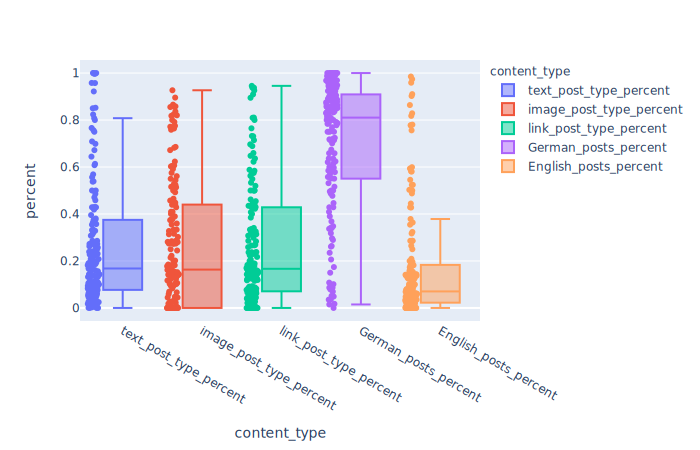

In [32]:
fig = px.box(
    df_plot_types,
    x='content_type',
    color='content_type',
    y="percent",
    points="all",
    # log_y=True,
)
# fig.show()
fig.show(renderer='svg')

In [33]:
df_subs[l_cols_pct_type].describe().T

,count,mean,std,min,25%,50%,75%,max
text_post_type_percent,162.0,0.265922,0.264871,0.0,0.077204,0.168024,0.372159,1.000000
image_post_type_percent,162.0,0.259736,0.272189,0.0,0.000000,0.163306,0.439783,0.926708
link_post_type_percent,162.0,0.261514,0.249870,0.0,0.071145,0.166667,0.428571,0.945455
German_posts_percent,162.0,0.695352,0.287072,0.0,0.550725,0.810356,0.908267,1.000000
English_posts_percent,162.0,0.174838,0.243492,0.0,0.022609,0.070417,0.182955,0.985149


# Append metadata to posts

In [34]:
%%time

df_v_subs_tsne_meta = (
    df_v_subs_merged_tsne2
    .reset_index()
    .drop(['subreddit_id', 'combined_topic_and_rating'], axis=1)
    .merge(
        df_subs,
        how='left',
        on=['subreddit_name']
    )
)
df_v_subs_tsne_meta.shape

CPU times: user 9.41 ms, sys: 380 µs, total: 9.79 ms
Wall time: 8.79 ms


(167, 43)

In [35]:
%%time

df_v_posts_tsne_meta = (
    df_v_posts_merged_tsne2
    .reset_index()
    .drop(['subreddit_name', 'subreddit_id'], axis=1)
    .merge(
        df_posts,
        how='left',
        on=['post_id']
    )
)
df_v_posts_tsne_meta.shape

CPU times: user 246 ms, sys: 37.1 ms, total: 283 ms
Wall time: 281 ms


(111669, 23)

### for test map, exclude most NSFW posts

nvm. maybe do later?

In [36]:
# maks_svd_exclude_most_nsfw_posts = ~(
#     df_vect_svd
#     .reset_index()
#     ['subreddit_name'].isin(l_large_nsfw_subs)
# )
# maks_svd_exclude_most_nsfw_posts.sum()

## General things plot by (as color or size)

Might need to create some aggregates/roll-ups for some of these:

#### Post level
- subreddit_name
- new_topic_and_rating
- weighted_language_top
- post_type
    - maybe images are more similar? b/c they're short
- post_nsfw
- text_len bins
    - maybe posts that are really short are close together?
**size:**
- upvotes
- comments
- text_len

#### Subreddit level
- subreddit_name
- new_topic_and_rating
- weighted_language_top (aggregated)
- post_type (aggregated)
    - maybe images are more similar?
- post_nsfw (aggregated)
    - this might not be necessary given that I already have over-18 flag?
- text_len bins (aggregated)
    - maybe posts that are really short are close together?

**size:**
- views, l28
- post count
- comments count



# Plot as scatter


In [40]:
# meta for all posts
n_posts = len(df_v_posts_tsne_meta)
n_subs = df_v_posts_tsne_meta['subreddit_name'].nunique()
first_date = df_v_posts_tsne_meta['submit_date'].min()
last_date = df_v_posts_tsne_meta['submit_date'].max()


## By NSFW

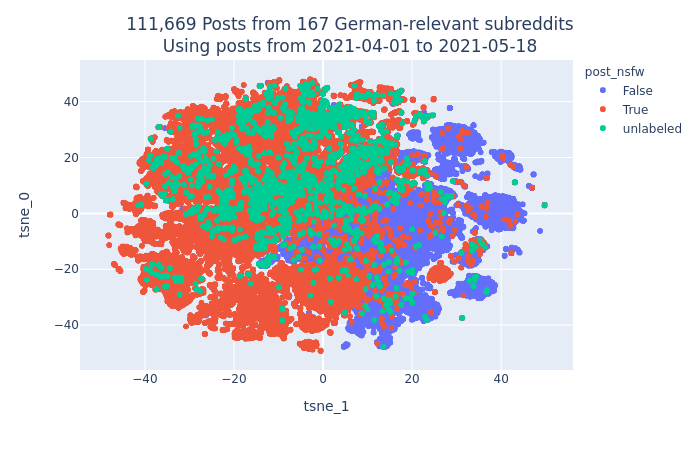

CPU times: user 607 ms, sys: 28.9 ms, total: 636 ms
Wall time: 1.78 s


In [43]:
%%time

posts_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
   "post text: %{customdata[2]}",
])

fig = px.scatter(
    df_v_posts_tsne_meta,
    y='tsne_0', x='tsne_1',
    color='post_nsfw',
#     custom_data=['subreddit_name', 'new_topic_and_rating', 'text'],
)
# fig.update_traces(hovertemplate=posts_hover_data)
fig.update_layout(
    title_text=(
        f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
        f"<br>Using posts from {first_date} to {last_date}"
    ),
    title_x=0.5,
    width=900,
    height=700,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
# fig.show()
fig.show(renderer='png')

In [44]:
%%time

fig = px.scatter(
    df_emb_svd2,
    y='tsne_0', x='tsne_1',
    color='weighted_language_top'
)
fig.update_layout(
    title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
    title_x=0.5,
    width=1100,
    height=800,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
# fig.show()
fig.show(renderer='png')

NameError: name 'df_emb_svd2' is not defined

In [134]:
# %%time

# fig = px.scatter_3d(
#     df_embeddings,
#     x='tsne_0', y='tsne_1', z='tsne_2',
#     color='subreddit_name'
# )
# fig.show()

In [45]:
%%time

fig = px.scatter(
    (
        df_emb_svd2
        .assign(
            subreddit_name_sparse=np.where(
                df_emb_svd2.index.isin(df_emb_svd2.sample(60, random_state=42).index),
                df_emb_svd2['subreddit_name'],
                ''
            )
        )
    ),
    y='tsne_0', x='tsne_1',
    color='subreddit_name',
    text='subreddit_name_sparse',
)
fig.update_traces(textposition='top center')
fig.update_layout(
    title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
    title_x=0.5,
    width=1100,
    height=800,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
# fig.show()
fig.show(renderer='png')

NameError: name 'df_emb_svd2' is not defined

In [162]:
value_counts_and_pcts(
    df_posts,
    ['combined_topic_and_rating'],
    top_n=None,
    reset_index=True,
).set_caption(f"Count of posts by previous subreddit category")

,combined_topic_and_rating,count,percent,cumulative_percent
0,uncategorized,"73,193",65.5%,65.5%
1,internet culture and memes,"14,912",13.4%,78.9%
2,place,"6,218",5.6%,84.5%
3,podcasts and streamers,"3,555",3.2%,87.7%
4,over18_nsfw,"2,780",2.5%,90.1%
5,"business, economics, and finance","1,895",1.7%,91.8%
6,funny/humor,"1,205",1.1%,92.9%
7,none of these topics,"1,070",1.0%,93.9%
8,sports,964,0.9%,94.7%
9,meta/reddit,907,0.8%,95.5%


In [315]:
get_colormap(8, return_as_list=True)

array(['#FF4500', '#0DD3BB', '#0079D3', '#FFB000', '#00A6A5', '#FF8717',
       '#24A0ED', '#FFCA00'], dtype='<U7')

In [46]:
# %%time

# fig = px.scatter(
#     (
#         df_emb_svd2
#         .assign(
#             subreddit_name_sparse=np.where(
#                 df_emb_svd2.index.isin(df_emb_svd2.sample(60, random_state=42).index),
#                 df_emb_svd2['subreddit_name'],
#                 ''
#             )
#         )
#     ),
#     y='tsne_0', x='tsne_1',
#     color='new_topic_and_rating',
#     text='subreddit_name_sparse',
#     # color_discrete_sequence=get_colormap(8, return_as_list=True),
# )
# fig.update_traces(textposition='top center')
# fig.update_layout(
#     title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
#     title_x=0.5,
#     width=1100,
#     height=800,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()


In [138]:
# %%time

# fig = px.scatter_3d(
#     df_embeddings[df_embeddings['weighted_language'] == 'de'],
#     x='tsne_0', y='tsne_1', z='tsne_2',
#     color='subreddit_name'
# )
# fig.show()

### limit to posts with more words

In [139]:
# %%time

# fig = px.scatter_3d(
#     df_embeddings[df_embeddings['text_word_count_estimate'] >= 6],
#     x='tsne_0', y='tsne_1', z='tsne_2',
#     color='subreddit_name'
# )
# fig.show()

In [140]:
# %%time

# fig = px.scatter(
#     df_emb_svd2[df_emb_svd2['text_word_count_estimate'] >= 5],
#     x='tsne_0', y='tsne_1',
#     color='subreddit_name',
# )
# fig.update_layout(
#     title_text="26k Posts from 84 German-relevant subreddits<br>Using posts from 04-01-2021 to 05-08-2021",
#     title_x=0.5,
#     width=1100,
#     height=800,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

# Load data for subreddit meta

Use this data to check how close subreddits are to each other

In [170]:
%%time

bucket_ = 'i18n-subreddit-clustering'
subs_path = 'subreddits/2021-06-01'

df_subs = pd.read_parquet(
    path=f"gs://{bucket_}/{subs_path}",
)

CPU times: user 37.9 ms, sys: 0 ns, total: 37.9 ms
Wall time: 623 ms


In [171]:
df_subs.shape

(196, 34)

In [244]:
new_place_culture = 'place/culture'
new_cult_ent_music = 'culture, entertainment, music'

d_old_topics_to_new_topics = {
    'food': 'food and drink',
    'culture + entertainment': new_cult_ent_music,
    'place': new_place_culture,
}
d_subs_to_new_topics = {
    'de_iama': 'reddit institutions',
    'askswitzerland': 'reddit institutions',
    'fragreddit': 'reddit institutions',
    'askagerman': 'reddit institutions',
    
    'wasletztepreis': 'internet culture and memes',
    'einfach_posten': 'internet culture and memes',

    'de': new_place_culture,
    'switzerland': new_place_culture,
    'wien': new_place_culture,
    'zurich': new_place_culture,
    
    'germanrap': new_cult_ent_music,
    
    'fahrrad': 'sports',
    
}

df_subs['new_topic_and_rating'] = np.where(
    df_subs['subreddit_name'].isin(d_subs_to_new_topics.keys()),
    df_subs['subreddit_name'].replace(d_subs_to_new_topics),
    df_subs['combined_topic_and_rating'].replace(d_old_topics_to_new_topics)
)

In [245]:
value_counts_and_pcts(
    df_subs,
    ['new_topic_and_rating']
)

,count,percent,cumulative_percent
new_topic_and_rating,,,
over18_nsfw,51,26.0%,26.0%
gaming,29,14.8%,40.8%
uncategorized,22,11.2%,52.0%
reddit institutions,21,10.7%,62.8%
food and drink,18,9.2%,71.9%
sports,13,6.6%,78.6%
internet culture and memes,12,6.1%,84.7%
"culture, entertainment, music",11,5.6%,90.3%
place/culture,8,4.1%,94.4%


# Average all posts for each subreddit
For the most basic baseline, average without any weights

In [246]:
# df_sub_agg = (
#     df_embeddings
#     .groupby(['subreddit_name'])
#     .agg(
#         tsne_0_mean= ('tsne_0', 'mean'),
#         tsne_1_mean= ('tsne_1', 'mean'),
#         tsne_2_mean= ('tsne_2', 'mean')
#     )
#     .reset_index()
# )

In [247]:
# df_emb_svd2.head()

In [248]:
l_keys_sub_only = ['subreddit_name', 'subreddit_id', ]
df_sub_agg2 = (
    df_emb_svd2
    .groupby(l_keys_sub_only)
    .agg(
        tsne_0_mean= ('tsne_0', 'mean'),
        tsne_1_mean= ('tsne_1', 'mean'),
    )
    .reset_index()
)

In [249]:
df_sub_agg2.head()

,subreddit_name,subreddit_id,tsne_0_mean,tsne_1_mean
0,600euro,t5_3caax,3.585606,9.876889
1,aeiou,t5_2qmr6,-6.828277,6.536946
2,annitheduck,t5_22ov32,-21.536810,-0.383880
3,annode,t5_4boee2,0.828407,8.482455
4,aoede,t5_3lvit,-9.518249,6.543109


In [166]:
(
    df_sub_agg2
    .set_index(l_keys_sub_only)
).to_parquet(
    path_this_ft_model / (
        f'df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-'
        f"{len(df_sub_agg2)}_by_{len([c for c in df_sub_agg2.columns if 'tsne_' in c])}.parquet"
    )
)

## Calculate mean & similarity from full embeddings, not tSNE

For visualizing it's prob ok to use tSNE mean, but for similarity, we want to go to raw embeddings to reduce the amount of data lost

In [251]:
df_sub_agg_full = (
    df_v_posts_combined.reset_index()
    .drop(['subreddit_id', 'post_id'], axis=1)
    .groupby(['subreddit_name'])
    .mean()
)
df_sub_agg_full.shape

(167, 300)

In [252]:
df_sub_agg_full.head()

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_270,embeddings_271,embeddings_272,embeddings_273,embeddings_274,embeddings_275,embeddings_276,embeddings_277,embeddings_278,embeddings_279,embeddings_280,embeddings_281,embeddings_282,embeddings_283,embeddings_284,embeddings_285,embeddings_286,embeddings_287,embeddings_288,embeddings_289,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
subreddit_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
600euro,-0.056097,-0.089395,0.015974,-0.005018,0.023330,0.022152,-0.002783,-0.021871,-0.043732,-0.049220,-0.039261,-0.034671,0.076387,-0.013788,-0.043126,0.011096,-0.045296,0.016380,0.054391,-0.071659,-0.026180,-0.044957,0.000353,0.011979,-0.052296,-0.009709,-0.010342,0.013554,-0.025211,-0.014997,...,0.007285,0.036028,0.039035,-0.014159,-0.029628,-0.009700,0.226709,0.021099,0.026198,-0.029759,0.051382,0.049686,0.022880,0.006063,0.012673,0.026991,-0.021102,0.023435,0.011565,0.012664,0.000538,0.001504,0.008652,-0.008729,0.052968,-0.029774,-0.001341,-0.005947,0.033296,-0.002058
aeiou,-0.044843,-0.067637,-0.059186,0.001504,0.117250,0.011028,0.016169,-0.052084,-0.019102,-0.027699,-0.046281,-0.028803,0.064018,-0.004742,-0.018366,-0.042611,-0.058533,0.028080,0.071035,-0.045283,-0.044804,-0.012009,0.025140,0.044963,-0.032300,-0.013813,0.034330,0.019123,-0.042469,0.026310,...,-0.074763,-0.042564,-0.007689,-0.005031,-0.002661,0.027628,0.317431,-0.011580,0.035057,0.019960,-0.008057,0.066430,0.033137,0.030882,0.025987,-0.024277,0.005277,0.001736,0.026365,-0.035302,0.008729,-0.030942,0.031329,-0.001322,0.013538,-0.054848,-0.004751,0.010903,-0.016563,0.000898
annitheduck,0.003245,-0.022748,-0.072708,-0.012507,0.013814,0.028160,0.002482,-0.044001,-0.067160,0.045121,0.025043,-0.016472,0.032452,0.049443,-0.007161,0.043062,-0.016407,-0.005825,-0.013494,0.134676,-0.024583,0.054962,-0.021347,0.038949,-0.043909,0.004026,0.101471,0.000661,-0.017605,0.135993,...,-0.005981,0.005002,0.017424,-0.029621,-0.013061,0.102890,0.295425,-0.012882,-0.069216,0.054666,-0.061630,0.007419,0.063693,0.009277,-0.005596,-0.007129,-0.004433,0.019717,-0.038138,0.001874,0.001718,0.039006,-0.044160,0.048524,-0.051928,0.060302,0.002733,-0.000191,-0.067144,0.025380
annode,-0.108932,-0.114309,0.077818,-0.028725,0.062160,0.065837,-0.031688,-0.012431,-0.040389,-0.011373,-0.044842,-0.062076,0.075013,-0.021464,-0.003046,-0.015250,-0.093971,-0.056135,0.070532,-0.097698,-0.021718,-0.013283,-0.023269,0.012702,-0.080467,-0.017558,-0.007843,0.009206,-0.007937,0.002717,...,-0.008580,0.022350,0.036222,-0.007112,-0.014167,-0.024921,0.209309,-0.001488,0.034453,0.024321,0.088789,0.016658,-0.023449,-0.008358,0.005156,-0.024323,-0.009857,0.013504,-0.027247,-0.008011,-0.020549,-0.029878,-0.025812,0.008094,-0.012961,-0.060731,-0.024574,-0.021143,0.049567,-0.021636
aoede,-0.086355,-0.007575,0.043986,-0.034242,0.095634,0.065108,-0.058386,0.000151,-0.012537,0.008805,-0.015355,-0.020476,0.054744,-0.013023,-0.013225,0.017113,-0.098452,-0.038042,0.035860,-0.037167,-0.015294,-0.012553,-0.012967,-0.058517,-0.043168,0.009360,0.042297,-0.022306,0.000482,0.020737,...,0.028708,0.004306,0.021454,-0.032601,-0.044138,0.019203,0.200470,0.004451,-0.045692,0.045484,0.028298,0.009521,-0.012782,0.010402,-0.007672,-0.013411,-0.004281,-0.022747,-0.056909,-0.001450,0.048297,-0.043663,-0.041803,0.083264,-0.032093,-0.045378,-0.045015,0.005699,-0.002888,-0.018308


In [253]:
from sklearn.metrics.pairwise import cosine_similarity

In [197]:
%%time

df_sim_sub = pd.DataFrame(
    cosine_similarity(df_sub_agg_full),
    index=df_sub_agg_full.index,
    columns=df_sub_agg_full.index,
)

df_sim_sub.columns.name = None

df_sim_sub.shape

CPU times: user 2.93 ms, sys: 715 µs, total: 3.64 ms
Wall time: 1.26 ms


(167, 167)

In [196]:
df_sim_sub.head()

,600euro,aeiou,annitheduck,annode,aoede,apexlegendsde,asiatischkochen,askagerman,askswitzerland,augenbleiche,augenschmaus,austria,backen,battlefieldde,berlin,bestofde,beziehungen,bibisbeautypalacensfw,bier,boahalter,buehne,buenzli,bundesliga,clashofclansde,coronavirusdach,counterstrikede,dachschaden,de,de_edv,de_iama,...,rocketbeans,rustde,schach,shirindavid,sommerspiele,sonnyloops,spabiergang,spacefrogs,spube,streamen,studentenkueche,switchde,switzerland,tischtennis,tja,totalwarde,valheimde,vegande,veganerezepte,vegetarischde,vegetarischkochen,wandern,wasletztepreis,wien,wirklichgutefrage,wixbros,xboxde,yottalifeof,zeldade,zurich
600euro,1.000000,0.687547,0.080518,0.737162,0.414116,0.290433,0.681541,-0.072130,-0.141047,0.725889,0.571317,0.754730,0.662711,0.477268,0.010502,0.755811,0.501191,0.346133,0.419869,0.495628,0.482665,0.479039,0.256993,0.386556,0.703241,0.353802,0.934440,0.896639,0.728161,0.917507,...,0.738565,0.255141,0.650615,0.648387,0.571776,0.656364,0.809738,0.757276,0.694160,0.631108,0.663470,0.585359,-0.079189,0.466930,0.498556,0.642729,0.486663,0.783268,0.659767,0.835728,0.621449,0.744423,0.893286,0.371778,0.847003,0.609712,0.316369,0.535093,0.660876,-0.064164
aeiou,0.687547,1.000000,0.279968,0.591487,0.348551,0.329669,0.590707,0.088141,-0.002340,0.549889,0.515418,0.731770,0.535978,0.369341,0.148342,0.578564,0.300401,0.342867,0.560987,0.477123,0.466794,0.739081,0.385752,0.331832,0.609993,0.333263,0.626769,0.737875,0.547325,0.639373,...,0.652294,0.392315,0.580129,0.476748,0.491537,0.477222,0.713478,0.656864,0.617872,0.444280,0.567867,0.419433,0.069866,0.459033,0.485129,0.412219,0.461041,0.629673,0.527142,0.591618,0.540303,0.532783,0.673172,0.463593,0.640518,0.456798,0.288116,0.435830,0.454246,0.092801
annitheduck,0.080518,0.279968,1.000000,0.105153,0.278121,0.298153,0.124410,0.734900,0.691447,0.129721,0.143126,0.463863,0.162992,0.231823,0.759194,0.173988,-0.043359,0.793051,0.528341,0.287423,0.024976,0.512335,0.649308,0.120533,0.194197,0.351841,0.097036,0.183256,0.156914,0.046923,...,0.415934,0.330699,0.170919,0.383450,0.113360,0.381208,0.138343,0.325363,0.194433,0.041982,0.105567,0.162027,0.706325,0.091886,0.309209,0.055959,0.341795,0.255527,0.097128,0.040769,0.113400,0.062617,0.103160,0.696827,0.048912,0.184290,0.181137,0.374068,0.150710,0.714174
annode,0.737162,0.591487,0.105153,1.000000,0.609971,0.345936,0.497605,-0.003626,-0.072640,0.586021,0.415457,0.634399,0.473235,0.513783,0.071769,0.670704,0.425157,0.287968,0.390000,0.377750,0.478097,0.440442,0.258109,0.379809,0.587667,0.331101,0.718049,0.712756,0.599432,0.734603,...,0.640328,0.302461,0.547952,0.511814,0.520986,0.509416,0.683339,0.566697,0.510336,0.550171,0.472625,0.495862,0.004352,0.439607,0.364764,0.733410,0.511916,0.616803,0.492070,0.620049,0.432324,0.629918,0.729785,0.339728,0.674251,0.458787,0.366367,0.434599,0.591149,0.025010
aoede,0.414116,0.348551,0.278121,0.609971,1.000000,0.402782,0.236909,0.301525,0.215906,0.323262,0.204221,0.524325,0.263774,0.459632,0.313889,0.464809,0.312914,0.372337,0.377963,0.287621,0.288191,0.414240,0.393749,0.549379,0.427032,0.389816,0.457087,0.472232,0.443081,0.414299,...,0.504422,0.271145,0.383205,0.284564,0.336489,0.308048,0.384494,0.460114,0.293946,0.342022,0.211572,0.416918,0.280545,0.322216,0.270607,0.573444,0.345343,0.402424,0.211949,0.299633,0.194861,0.361630,0.420298,0.405105,0.399293,0.234831,0.378489,0.442050,0.488466,0.282493


In [198]:
# remove self comparisson, b/c it should be same
# df_sim = df_sim[df_sim < 0.999999]

In [254]:
df_topics_new = value_counts_and_pcts(
    df_subs['new_topic_and_rating'],
    top_n=None,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=True
)
style_df_numeric(df_topics_new, l_bar_simple=df_topics_new.columns)

,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
over18_nsfw,51,26.02%,26.02%
gaming,29,14.80%,40.82%
uncategorized,22,11.22%,52.04%
reddit institutions,21,10.71%,62.76%
food and drink,18,9.18%,71.94%
sports,13,6.63%,78.57%
internet culture and memes,12,6.12%,84.69%
"culture, entertainment, music",11,5.61%,90.31%
place/culture,8,4.08%,94.39%
podcasts and streamers,5,2.55%,96.94%


In [223]:
from subclu.models.model_utils import get_most_similar_items

In [295]:
l_col_most_similar = [
    'subreddit_name',
    'new_topic_and_rating',
    'rating',
    'over_18',
    'whitelist_status',
    'users_l28',
    'subscribers',
    'posts_l28',
    'comments_l28',
    'subreddit_title',
    'subreddit_public_description',
]
l_col_most_similar_no_txt = [
    'subreddit_name',
    'new_topic_and_rating',
    'rating',
    'over_18',
    'whitelist_status',
    'users_l28',
    'subscribers',
    'posts_l28',
    'comments_l28',
]


In [297]:
top_subs_per_category = 1

for topic_ in df_topics_new[df_topics_new['subreddits_count'] > 25].index:
    largest_communities = (
        df_subs
        [df_subs['new_topic_and_rating'] == topic_]
        .sort_values(by=['users_l28'], ascending=False)
#         ['subreddit_name'].values
    )
    print(f"\n\nTopic: {topic_}\n==="
          f'\nLargest communities:')
    display(style_df_numeric(largest_communities[l_col_most_similar_no_txt].head()))
    
    for n_ in range(top_subs_per_category):
#         print(f"\n{largest_communities['subreddit_name'].values[n_]}\n---")
        display(
            style_df_numeric(
                get_most_similar_items(
                    largest_communities['subreddit_name'].values[n_],
                    df_sim_sub, df_subs, top_n=10,
                    col_meta_merge='subreddit_name',
                    meta_cols_to_merge=l_col_most_similar,
                ),
                int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
            )
        )




Topic: over18_nsfw
===
Largest communities:


,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28
7,nicoledobrikov,over18_nsfw,None,t,None,"840,306","129,046",10,"3,004"
8,germansgonewild,over18_nsfw,x,t,no_ads,"350,954","124,164","2,216","18,030"
15,elisaalineunconsored,over18_nsfw,None,t,None,"275,124","72,091",467,996
40,elisaaline1,over18_nsfw,None,t,no_ads,"191,354","19,617",27,"2,806"
92,katjakrasavicenudes,over18_nsfw,None,t,None,"188,112","5,763","7,165","5,392"


,nicoledobrikov,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,nicoledobrikov,over18_nsfw,None,t,None,"840,306","129,046",10,"3,004",NicoleDobrikov,"Ein Subreddit für Nicole Dobrikov, Influencerin aus Instagram und TikTok"
1,0.79,nicoledobri,uncategorized,None,None,None,"39,884","1,840",123,100,NicoleDobri,Nicole Dobrikov Onlyfans
2,0.74,nicoledobrikov1,uncategorized,None,f,no_ads,"457,343","21,468",36,"11,505",Nicole Dobrikov Fans,None
3,0.73,papaplatte,podcasts and streamers,pg,None,all_ads,"34,986","73,998",333,749,Papaplatte Subreddit,"Hier kannst du alles bezüglich Papaplatte posten, egal ob Memes, Fanarts oder Vorschläge für den Stream."
4,0.72,germancelebritiesfap2,over18_nsfw,None,t,None,"146,634","10,535",420,524,germanCelebritiesFAP2,"Das Sub für alles Schöne aus Deutschland. Postet hier gerne Bilder und Videos von deutschen Promis. - Bitte im Titel den Namen aufnehmen - Keine Bedingungen / DM Aufforderungen - Kein SPAM, nur on-topic - Keine Beleidigungen oder abfällige Bemerkungen und seit nett zueinander"
5,0.72,kellymissesvlog,over18_nsfw,nc17,None,no_ads,"46,952","19,986",72,127,"Bilder, Screenshots und Clips rund um die Youtuberin Kelly Missesvlog","Bilder, screenshots und Clips rund um die Youtuberin Kelly Missesvlog. Folgt ihr auf Social Media: - https://www.youtube.com/user/MissesVlog - https://www.twitch.tv/kellylein/videos - http://instagram.com/kel - http://twitter.com/MissesVlog"
6,0.71,germancelebnew,over18_nsfw,None,t,None,"45,586","7,775",111,122,GermanCelebNew,"Wir möchten hier nur deutsche weibliche Prominente. Anfragen zum Bildertausch, RP, wichsen, cumtributes, discord links irgendwas mit Klassenkameraden oder fakes werden hier nicht gestattet und führen sofort zum Bann. Keine Werbung für andere subreddits ohne Absprache mit einem mod Das posten von Minderjährigen ist strengstens verboten. Bitte achtet auf eure Wortwahl Ansonsten ist hier jeglicher Austausch gestattet und gewünscht. Keine Beleidigungen den promis oder Usern gegenüber."
7,0.69,nicoledobrikovofs,nan,nan,nan,nan,-,-,-,-,nan,nan
8,0.69,loredana,nan,nan,nan,nan,-,-,-,-,nan,nan
9,0.68,influencernsfw,uncategorized,None,f,None,"31,445","5,846","1,226",56,InfluencerNSFW,"Willkommen bei InfluencerNSFW, einem Subreddit für Bilder von deutschen Influencerinnen und Promis!"




Topic: gaming
===
Largest communities:


,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28
132,annode,gaming,None,None,all_ads,"6,774",453,65,235
125,nintendode,gaming,None,f,None,"6,591",836,42,82
141,pcbaumeister,gaming,None,None,all_ads,"2,649",218,54,290
143,aoede,gaming,None,None,all_ads,"2,460",160,46,90
154,totalwarde,gaming,None,None,all_ads,"1,013",41,27,10


,annode,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,annode,gaming,None,None,all_ads,"6,774",453,65,235,AnnoDE,Willkommen auf dem deutschsprachigen Ort auf Reddit für alles rund um die Anno-Serie!
1,0.77,heutelernteich,reddit institutions,None,None,all_ads,"3,872","1,501",73,61,Heute Lernte Ich,Du hast heute etwas Interessantes gelernt? Teile es mit der Reddit Community! Oder folge dem Subreddit um neue Dinge zu lernen.
2,0.75,geschichtsmaimais,internet culture and memes,pg,None,all_ads,"13,831","14,781",155,"1,397",Ein Unter für Geschichtsmaimais,"Geschichte ist toll, Maimais auch warum nicht beides kombinieren? Hier könnt ihr Geschichtsmaimais pfostieren und sie mit Freunden der Geschichte teilen. Bitte Pfostiert aber nur auf Deutsch für Angelsachsen ist der r/historymemes Unter da."
3,0.74,rbtv_cj,internet culture and memes,pg,f,all_ads,"36,180","6,777",269,"9,159",Rocket Beans Circlejerk,
4,0.74,600euro,internet culture and memes,r,None,some_ads,"74,326","31,334",541,"13,335",Offizielle Außenstelle der deutsch GmbH kolonie der USA.,"Hier passen Geschichten von sozialen Medien hinein, welche zwar behaupten, wahr zu sein, aber einfach sehr schlecht und unglaubwürdig sind. Gute Beispiele hierfür sind schlechte Hetzposts gegen Asylsuchende, oder Kettenbriefe."
5,0.73,de_iama,reddit institutions,pg,None,all_ads,"66,694","385,199",65,"4,194",Triff interessante Leute und frage ihnen Löcher in den Bauch!,Die deutschsprachige Version von /r/IAMA
6,0.73,mauerstrassenwetten,internet culture and memes,r,None,some_ads,"124,140","96,746",705,"67,821",mauerstrassenwetten,Als hätte 4chan ein Bloomberg Terminal gefunden; Aber auf Deutsch! Für Anfragen per Mail: mods@mauerstrassenwetten.de
7,0.73,totalwarde,gaming,None,None,all_ads,"1,013",41,27,10,TotalWarDE,Die deutschsprachige Community auf Reddit für alles rund um die Total War-Reihe!
8,0.73,laesterschwestern,podcasts and streamers,pg,f,all_ads,"56,212","14,799",107,"1,208",Lästerschwestern Podcast,"Das Reddit rund um den Podcast Lästerschwestern. Hier diskutieren und lästern YouTuber Robin Blase & Journalistin Lisa Ludwig über YouTube, das Internet, Social Media und Influencer. Hauptsache lästern! Hier diskutiert Robin auch mit /u/robbubble. Ehemaliger Co-Host & Gründungsmitglied /u/David_BeHaind bleibt Ehrenmitglied und immer in unseren Herzen <3"
9,0.73,fragreddit,reddit institutions,pg,f,all_ads,"104,939","28,286",641,"11,745",Frag Reddit - auf Deutsch,None


### Add more meta columns for each sub

In [256]:
df_sub_agg2 = df_sub_agg2.merge(
    df_subs,
    how='left',
    on=l_keys_sub_only,
)

In [298]:
df_sub_agg2['new_topic_and_rating'] = df_sub_agg2['new_topic_and_rating'].fillna('uncategorized')

In [299]:
#  %%time

# fig = px.scatter_3d(
#     df_sub_agg,
#     x='tsne_0_mean', y='tsne_1_mean', z='tsne_2_mean',
#     color='subreddit_name'
# )
# fig.show()

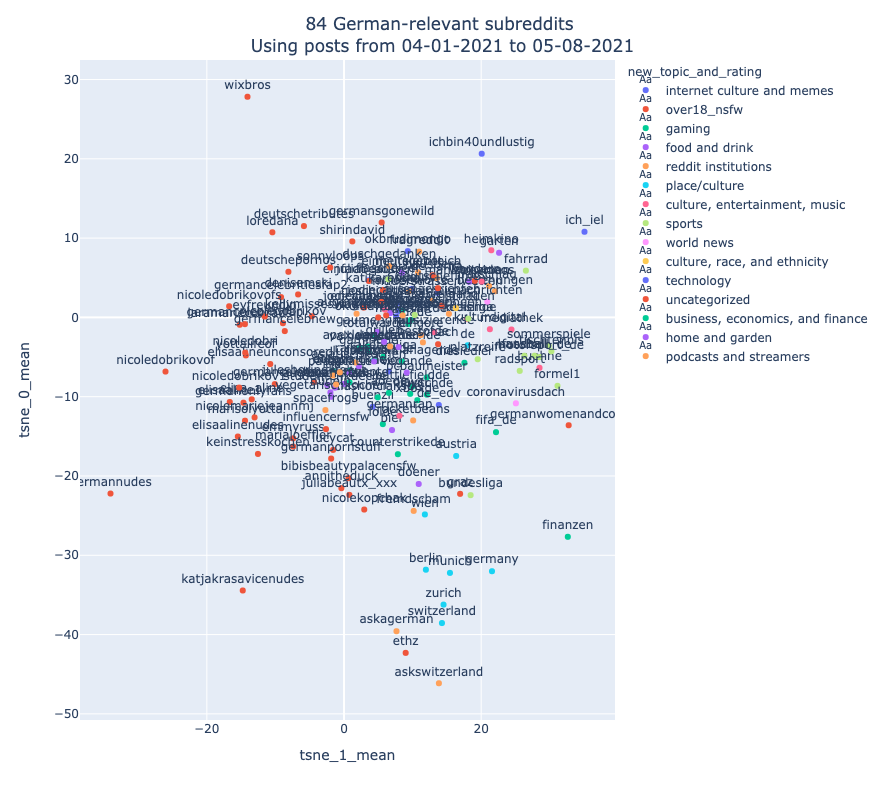

CPU times: user 104 ms, sys: 4.5 ms, total: 108 ms
Wall time: 105 ms


In [300]:
 %%time

fig = px.scatter(
    df_sub_agg2,
    y='tsne_0_mean', x='tsne_1_mean',
    color='new_topic_and_rating',
    text='subreddit_name',
)
fig.update_traces(textposition='top center')
fig.update_layout(
    title_text="84 German-relevant subreddits <br>Using posts from 04-01-2021 to 05-08-2021",
    title_x=0.5,
    width=1100,
    height=800,
    uniformtext_minsize=8, uniformtext_mode='hide',
)
fig.show()

In [319]:
# df_sim_sub.head()

In [320]:
style_df_numeric(
    get_most_similar_items(
        'fifa_de',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,fifa_de,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,fifa_de,gaming,None,None,all_ads,47,13,12,5,FIFA_DE,Das deutschsprachige FIFA-Subreddit für Fans der Fußball-Spielserie von EA Sports
1,0.63,battlefieldde,gaming,None,None,all_ads,351,459,31,20,BattlefieldDE,Das deutsche Subreddit rund um das beliebte Shooter-Franchise von EA und DICE und natürlich alle Neuigkeiten zu Battlefield 6
2,0.62,fussball,sports,None,None,all_ads,"5,479","1,182",258,471,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,Das deutschsprachige Subreddit rund um die schönste Nebensache der Welt!
3,0.58,footballmanagerde,gaming,None,None,all_ads,22,9,7,0,FootballManagerDE,Das Sub für alle FootballManager Fans!
4,0.56,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
5,0.56,radsport,sports,None,None,all_ads,649,116,121,90,Radsport auf Reddit.,"Die deutschsprachige Community für Radsport - von RTFs über Cyclocross und Mountainbikesport bis zu den UCI Klassikern. Tauscht Euch aus über Events, Training, Equipment und mehr."
6,0.54,platzreife,sports,None,None,all_ads,139,20,59,4,Platzreife,"Deutschsprachiges Clubhaus für alle Golfbegeisterten auf Reddit - ob mit oder ohne Platzreife. Tauscht Euch aus über Trainig, Equipment, Plätze, Tuniere und mehr."
7,0.54,xboxde,gaming,None,None,all_ads,396,27,22,18,Xbox auf Deutsch,Das deuschsprachige Subreddit für Xbox Enthusiasten!
8,0.52,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.
9,0.52,eurotruckde,gaming,None,None,all_ads,19,10,6,0,EuroTruckDE,Das Sub für alle Eurotruck Fans!


In [306]:
style_df_numeric(
    get_most_similar_items(
        'bier',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,bier,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,bier,food and drink,r,None,some_ads,"2,290","4,872",28,163,Bier,"r/Bier: The community for German, Dutch and Belgian beer lovers."
1,0.71,doener,food and drink,pg,None,all_ads,"30,745","20,623",33,333,/r/doener macht schöner,"Döner Kebab is one of the most famous dishes of the Turkish cuisine and is enjoying huge popularity in Germany and other european countries. Posts about similiar dishes from the Turkish, Greek or Arab cuisine are welcome."
2,0.69,buenzli,internet culture and memes,pg,None,all_ads,"26,435","41,849",278,"4,046",Will mer wüssed que nous sommes il migliore!,
3,0.68,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
4,0.68,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
5,0.66,germanrap,"culture, entertainment, music",r,None,some_ads,"58,657","17,606",513,"3,710",Das Deutschrap-Forum,"Für deutschen Rap und Rap aus Deutschland, sowie den umrahmenden Hip-Hop-Kontext."
6,0.61,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
7,0.61,graz,uncategorized,None,None,None,"6,844","7,835",107,"1,147",Verschiedenes aus Graz,Subreddit für die zweitgrößte Stadt Österreichs.
8,0.61,vegande,food and drink,pg,None,all_ads,"30,364","9,627",168,"2,811",Vegan auf Deutsch,"Informationen und Neuigkeiten über Veganismus in Deutschland, Österreich und der Schweiz."
9,0.60,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.


In [307]:
style_df_numeric(
    get_most_similar_items(
        'doener',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,doener,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,doener,food and drink,pg,None,all_ads,"30,745","20,623",33,333,/r/doener macht schöner,"Döner Kebab is one of the most famous dishes of the Turkish cuisine and is enjoying huge popularity in Germany and other european countries. Posts about similiar dishes from the Turkish, Greek or Arab cuisine are welcome."
1,0.72,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
2,0.71,bier,food and drink,r,None,some_ads,"2,290","4,872",28,163,Bier,"r/Bier: The community for German, Dutch and Belgian beer lovers."
3,0.68,berlin,place/culture,pg,f,all_ads,"192,402","118,917","1,141","18,886",Neues Aus Berlin,"The bilingual subreddit for everything relating to Berlin, capital city of Germany."
4,0.67,munich,place/culture,pg,None,all_ads,"35,498","43,887",301,"2,464",Subreddit für München,None
5,0.66,germanpornstuff,over18_nsfw,None,t,None,"51,912","23,786",175,283,Porn from Germany - Filthy as ever …,Teutonic Porn and Adult Cöntent
6,0.65,germany,place/culture,pg,f,all_ads,"388,455","286,701","1,992","22,197",Germany,English-language discussions and news relating to Germany and German culture.
7,0.65,zurich,place/culture,pg,None,no_ads,"16,415","20,145",102,"1,134",Zürich,Subreddit for the beautiful city and canton of Zurich
8,0.63,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
9,0.63,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."


In [308]:
style_df_numeric(
    get_most_similar_items(
        'wien',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,wien,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
1,0.86,berlin,place/culture,pg,f,all_ads,"192,402","118,917","1,141","18,886",Neues Aus Berlin,"The bilingual subreddit for everything relating to Berlin, capital city of Germany."
2,0.86,munich,place/culture,pg,None,all_ads,"35,498","43,887",301,"2,464",Subreddit für München,None
3,0.83,germany,place/culture,pg,f,all_ads,"388,455","286,701","1,992","22,197",Germany,English-language discussions and news relating to Germany and German culture.
4,0.82,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
5,0.81,zurich,place/culture,pg,None,no_ads,"16,415","20,145",102,"1,134",Zürich,Subreddit for the beautiful city and canton of Zurich
6,0.80,graz,uncategorized,None,None,None,"6,844","7,835",107,"1,147",Verschiedenes aus Graz,Subreddit für die zweitgrößte Stadt Österreichs.
7,0.80,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."
8,0.80,switzerland,place/culture,pg13,f,no_ads,"87,226","114,933",670,"10,459",Switzerland,All things Switzerland!
9,0.79,ethz,uncategorized,pg13,None,all_ads,"9,544","7,960",61,524,ETH Zurich,are you studying? no? then go study.


In [309]:
style_df_numeric(
    get_most_similar_items(
        'germanwomenandcouples',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,germanwomenandcouples,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,germanwomenandcouples,uncategorized,None,f,None,"34,265","9,098","1,567","1,855",germanwomenandcouples,"Frauen und Paare zeigt euch sexy! Erotik, Sex und Nacktheit für Deutschland ����, Österreich ���� und die Schweiz ���� German speakers are also allowed to post. Links von anderen Seiten sind nicht erlaubt!"
1,0.70,bibisbeautypalacensfw,over18_nsfw,None,t,None,"37,947","9,206","1,471",491,BibisBeautyPalaceNSFW,Eine Community zum Austausch und Teilen von Bildern der deutschen YouTuberin BibisBeautyPalace.
2,0.67,juliabeautx_xxx,over18_nsfw,None,t,None,"30,219","6,409","1,412",249,JuliaBeautx_XXX,Sub für die wunderbre Julia Beautx. Viel Spaß beim posten :)
3,0.66,annitheduck,over18_nsfw,None,t,None,"65,341","18,073","1,541",325,Fansub für AnniTheDuck.,"Fan-Subreddit für YouTuberin, Streamerin und Cosplayerin Anni The Duck. Subreddit for YouTuber, Streamer and Cosplayer Anni The Duck."
4,0.61,marialoeffler,over18_nsfw,None,t,None,"65,123","3,781","1,500",708,Marialoeffler,MariaLoeffler
5,0.58,germanpornstuff,over18_nsfw,None,t,None,"51,912","23,786",175,283,Porn from Germany - Filthy as ever …,Teutonic Porn and Adult Cöntent
6,0.58,katjakrasavicenudes,over18_nsfw,None,t,None,"188,112","5,763","7,165","5,392",KatjaKrasaviceNudes,ONLY THE BEST AND HOTTEST PICS OF THE BOSSBITCH❤️
7,0.57,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
8,0.55,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."
9,0.55,elisaalineunconsored,over18_nsfw,None,t,None,"275,124","72,091",467,996,ElisaAlineUnconsored,alles dreht sich hier um Elisa Aline ohne Linkspams etc. ! ��


In [310]:
style_df_numeric(
    get_most_similar_items(
        'fifa_de',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,fifa_de,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,fifa_de,gaming,None,None,all_ads,47,13,12,5,FIFA_DE,Das deutschsprachige FIFA-Subreddit für Fans der Fußball-Spielserie von EA Sports
1,0.63,battlefieldde,gaming,None,None,all_ads,351,459,31,20,BattlefieldDE,Das deutsche Subreddit rund um das beliebte Shooter-Franchise von EA und DICE und natürlich alle Neuigkeiten zu Battlefield 6
2,0.62,fussball,sports,None,None,all_ads,"5,479","1,182",258,471,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,Das deutschsprachige Subreddit rund um die schönste Nebensache der Welt!
3,0.58,footballmanagerde,gaming,None,None,all_ads,22,9,7,0,FootballManagerDE,Das Sub für alle FootballManager Fans!
4,0.56,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
5,0.56,radsport,sports,None,None,all_ads,649,116,121,90,Radsport auf Reddit.,"Die deutschsprachige Community für Radsport - von RTFs über Cyclocross und Mountainbikesport bis zu den UCI Klassikern. Tauscht Euch aus über Events, Training, Equipment und mehr."
6,0.54,platzreife,sports,None,None,all_ads,139,20,59,4,Platzreife,"Deutschsprachiges Clubhaus für alle Golfbegeisterten auf Reddit - ob mit oder ohne Platzreife. Tauscht Euch aus über Trainig, Equipment, Plätze, Tuniere und mehr."
7,0.54,xboxde,gaming,None,None,all_ads,396,27,22,18,Xbox auf Deutsch,Das deuschsprachige Subreddit für Xbox Enthusiasten!
8,0.52,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.
9,0.52,eurotruckde,gaming,None,None,all_ads,19,10,6,0,EuroTruckDE,Das Sub für alle Eurotruck Fans!


# Upload saved files to GCS

In [267]:
path_this_ft_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17')

In [268]:
for f in [f for f in path_this_ft_model.glob('*') if f.is_file()]:
    print(f.name)

df_vectorized_posts_svd_tsne-init_pca-perplexity_30-rand_state_42-ids_index-111669_by_2.parquet
df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-28_by_2.parquet
df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-167_by_2.parquet
df_vectorized_posts_svd-ids_index-111669_by_50.parquet


In [269]:
bucket_upload_dir = f'gs://i18n-subreddit-clustering/data/models/fse/{path_this_ft_model.name}'
bucket_upload_dir

'gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17'

In [270]:
!echo $path_this_ft_model $bucket_upload_dir

/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17 gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17


In [271]:
!gsutil -m cp -r $path_this_ft_model $bucket_upload_dir

Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd_tsne-init_pca-perplexity_30-rand_state_42-ids_index-111669_by_2.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-28_by_2.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-167_by_2.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd-ids_index-111669_by_50.parquet [Content-Type=application/octet-stream]...
- [4/4 files][ 33.3 MiB/ 33.3 MiB] 100% Done                                    
Operation completed over 4 objects/33.3 MiB.               

# Subreddit level from the start
Instead of rolling up from post-level, what does a sub look like when we treat all posts as part of the same "document" from the start?
- This would be the doc2vec approach that Simon already uses for ads similarity subreddits.

# Other ways to get subreddit-level vectors


- Get mean of 300-len vectors AND then convert to t-SNE
- Merge posts for all subs and train a new uSIF model on the text
  - Downside: it'll take much longer to train
  - Upside: we'll be able to use `similarity` functions.
  
from tutorial:
> After training the sentence embedding we can access each individual embedding by its index or the complete embedding matrix. The syntax is as close to Gensims syntax as possible for easy usage...
> 
> The corresponding Sentencevectors (sv) class provides quite a few functions to work with the resulting sentence embeddings. For example, you can use similarity, distance, most_similar, similar_by_word, similar_by_sentence, or similar_by_vector.